In [1]:
import os
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

import torch
from torch import nn

## Utils

In [2]:
#concateners
"""allPath = ["../HGS/2113", "../HGS/2213", "../HGS/3113", "../HGS/3213"]
colNames = ["instance_name", "cost"] + ["S" + str(i) for i in range(1, 19)]

for path in allPath:
    filenames = os.listdir(path)
    allSepData = []
    for file in filenames:
        allSepData.append(pd.read_csv(path +"/"+ file, sep=";", names=colNames))
    data = pd.concat(allSepData)
    data.to_csv(path + "-dataset.csv", index=False)

fullSepData = []
for folderPath in allPath:
    fullSepData.append(pd.read_csv(folderPath +"-dataset.csv", sep=","))
fullData = pd.concat(fullSepData)
fullData.to_csv("../HGS/clean_dataset_v3.csv", index=False)"""

'allPath = ["../HGS/2113", "../HGS/2213", "../HGS/3113", "../HGS/3213"]\ncolNames = ["instance_name", "cost"] + ["S" + str(i) for i in range(1, 19)]\n\nfor path in allPath:\n    filenames = os.listdir(path)\n    allSepData = []\n    for file in filenames:\n        allSepData.append(pd.read_csv(path +"/"+ file, sep=";", names=colNames))\n    data = pd.concat(allSepData)\n    data.to_csv(path + "-dataset.csv", index=False)\n\nfullSepData = []\nfor folderPath in allPath:\n    fullSepData.append(pd.read_csv(folderPath +"-dataset.csv", sep=","))\nfullData = pd.concat(fullSepData)\nfullData.to_csv("../HGS/clean_dataset_v3.csv", index=False)'

In [3]:
def plotCurve(y_test, y_pred, beginInd=0, endInd=500):
    plt.figure(figsize=(15,5))
    y_test_sorted, y_pred_sorted = zip(*sorted(zip(y_test.to_list(), y_pred.tolist())))
    y_test_sorted, y_pred_sorted = y_test_sorted[beginInd:endInd], y_pred_sorted[beginInd:endInd]

    plt.plot([i for i in range(len(y_test_sorted))], y_test_sorted, color = 'magenta', label="True", linewidth = 3)
    plt.scatter([i for i in range(len(y_test_sorted))], y_pred_sorted, color = 'green', label="Prediction")
    plt.legend()
    plt.show()

In [4]:
def plot_histo(y_test, y_pred, nbars=1000, width = 0.02):
    maxValue=y_test.max()
    minValue=y_test.min()
    step = (maxValue-minValue)/nbars

    y_test_count=[0 for _ in range(nbars)]
    y_pred_count=[0 for _ in range(nbars)]
    for i in range(len(y_test)):
        ytestInd = int(y_test[i] // step)
        ypredInd = int(y_pred[i] // step)
        y_pred_count[ypredInd] += 1
        y_test_count[ytestInd] += 1

    xValues = [x*step+minValue for x in range(nbars)]
    plt.bar(xValues, y_test_count, label="True", width=width, color = 'magenta')
    plt.bar(np.array(xValues) + width, y_pred_count, label="Prediction", width=width, color = 'green')
    plt.legend()

## Loading Data

In [5]:
fullData = pd.read_csv("../HGS/clean_dataset_v3.csv", sep=",")

fullData = fullData.drop(columns=["S7", "S13"])

In [6]:
fullData.head()

,instance_name,cost,S1,S2,S3,S4,S5,S6,S8,S9,S10,S11,S12,S14,S15,S16,S17,S18
0,XML100_2113_01,13063,257.768,105.0410,0.2078,0.0803,534.2,133.2030,294.4,0.2274,0.1524,446.5,0.2066,0.0207,327.901,482.077,1.6125,3.5971
1,XML100_2113_01,13237,201.777,57.7145,0.1561,0.0349,576.7,74.8466,302.6,0.2275,0.1691,420.3,0.2113,0.0321,187.524,489.225,1.7889,4.1107
2,XML100_2113_01,13168,225.720,114.3020,0.1653,0.0572,552.8,112.2280,279.4,0.2105,0.1649,430.8,0.2062,0.0202,307.325,484.538,1.5492,3.7572
3,XML100_2113_01,13168,243.308,164.7820,0.2140,0.1242,539.6,157.2250,297.6,0.2452,0.1512,432.2,0.3636,0.2727,403.127,467.493,3.0000,3.5150
4,XML100_2113_01,13000,195.334,102.7790,0.1588,0.1049,563.7,79.7384,294.2,0.2256,0.1720,416.4,0.2074,0.0233,213.558,490.165,1.6125,3.9475


## Data sampling and Train-test splitting

In [7]:
chunkData = fullData.sample(1000000, random_state=123456)
chunkData = chunkData.drop(columns=["instance_name"])

chunkData.head()

,cost,S1,S2,S3,S4,S5,S6,S8,S9,S10,S11,S12,S14,S15,S16,S17,S18
12800051,14483,131.402,99.7370,0.0847,0.0643,559.667,299.700,448.750,0.3663,0.0872,805.167,0.3704,0.2457,637.502,345.401,2.2111,4.1302
5483954,10406,137.274,64.4632,0.1157,0.0859,454.500,100.664,293.000,0.2868,0.1268,525.600,0.2123,0.0329,249.455,352.032,1.8974,3.8180
10788912,20900,162.031,93.7861,0.0574,0.0474,973.900,281.018,759.600,0.3692,0.0821,1421.000,0.3636,0.2727,593.597,437.968,3.0000,4.7000
8346315,21353,230.727,149.5370,0.1096,0.0606,803.167,322.533,641.167,0.3607,0.1160,1117.000,0.3704,0.2457,724.450,496.813,2.2111,3.4688
134772,14324,266.923,133.4720,0.2667,0.2520,473.333,171.891,348.583,0.3057,0.1183,592.333,0.3704,0.2457,443.784,472.126,2.2111,2.9479


In [8]:
from torch.utils.data import Dataset
class MyDataset(Dataset):

  def __init__(self,x:np.ndarray, y:np.ndarray):
    self.x_train=torch.tensor(x, dtype=torch.float32)
    self.y_train=torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [9]:
y = chunkData.cost
x = chunkData.drop(columns=["cost"])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
#normalizing data, only according to train data mean and variance
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Prepare dataset
dataset = MyDataset(x=x_train, y=y_train.to_numpy())
dataset_test = MyDataset(x=x_test, y=y_test.to_numpy())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def model_rapport(name, y_test, y_pred, precision = 8):

    mae = round(mean_absolute_error(y_test, y_pred), precision)
    r2 = round(r2_score(y_test, y_pred), precision)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), precision)

    print(name, "--------------------------------------")
    print("MAE :", mae)
    print("RMSE :", rmse)
    print("R2 :", r2)

    return mae, rmse, r2

## Multi Layer Perceptron

In [11]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(16, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [25]:
# Initialize the MLP
PATH = './mlp.pth'
mlp = MLP()
#mlp.load_state_dict(torch.load(PATH))

In [26]:
mlp.to(device)
learning_rate = 1e-3
maxepochs = 20
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

In [27]:
lossProgress_train = []
lossProgress_test = []
for epoch in range(maxepochs):  # loop over the dataset multiple times
    t1 = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i % 1000 == 0: print("training on batch", i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp(inputs)
        #print(i, "forward done")
        loss = loss_function(outputs, labels)
        loss.backward()
        #print(i, "backward done")
        optimizer.step()
        #print(i, "optimize done")

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / len(trainloader):.3f}')
    print(f'[{epoch + 1}] time: {time.time()-t1:.3f}')
    lossProgress_train.append(running_loss / len(trainloader))

    #getting loss for test
    running_loss_test = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # forward + backward + optimize
        outputs = mlp(inputs)
        loss = loss_function(outputs, labels)
        running_loss_test += loss.item()
    print(f'[{epoch + 1}] test loss: {running_loss_test / len(testloader):.3f}')
    lossProgress_test.append(running_loss_test / len(testloader))

print('Finished Training')

training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
training on batch 7000
training on batch 8000
training on batch 9000
training on batch 10000
training on batch 11000
[1] loss: 5921823.391
[1] time: 189.640
[1] test loss: 12918.842
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
training on batch 7000
training on batch 8000
training on batch 9000
training on batch 10000
training on batch 11000
[2] loss: 8813.878
[2] time: 186.661
[2] test loss: 7584.786
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
training on batch 7000
training on batch 8000
training on batch 9000
training on batch 10000
training on batch 11000
[3] loss: 7166.283
[3] time: 199.463
[3] test los

### Loss progress

In [28]:
totalLossProgress_train = locals().get("totalLossProgress_train", [])
totalLossProgress_test = locals().get("totalLossProgress_test", [])

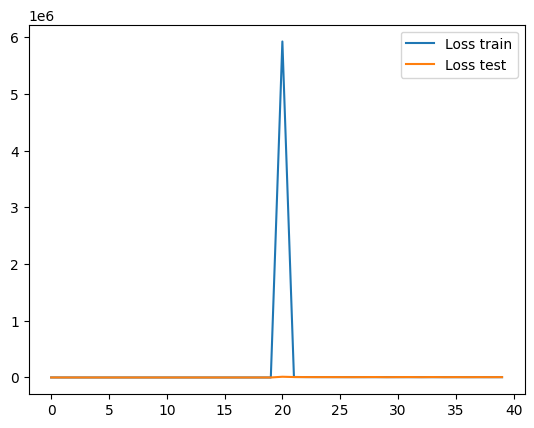

In [29]:
totalLossProgress_train += lossProgress_train
totalLossProgress_test += lossProgress_test

plt.plot([i for i in range(len(totalLossProgress_train))], totalLossProgress_train, label="Loss train")
plt.plot([i for i in range(len(totalLossProgress_test))], totalLossProgress_test, label="Loss test")
plt.legend()

In [30]:
PATH = './mlp.pth'
torch.save(mlp.state_dict(), PATH)

### Results and scores

In [31]:
mlp.cpu()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [32]:
y_pred = mlp(torch.tensor(x_test, dtype=torch.float32)).squeeze(-1).detach().numpy()
model_rapport("MLP", y_test=y_test, y_pred=y_pred)

MLP --------------------------------------
MAE : 60.88013859
RMSE : 79.41578685
R2 : 0.99975075


(60.88013859, 79.41578685, 0.99975075)

In [41]:
y_pred_train = mlp(torch.tensor(x_train, dtype=torch.float32)).squeeze(-1).detach().numpy()
model_rapport("MLP", y_test=y_train, y_pred=y_pred_train)

MLP --------------------------------------
MAE : 51.62748811
RMSE : 74.70212005
R2 : 0.99979775


(51.62748811, 74.70212005, 0.99979775)

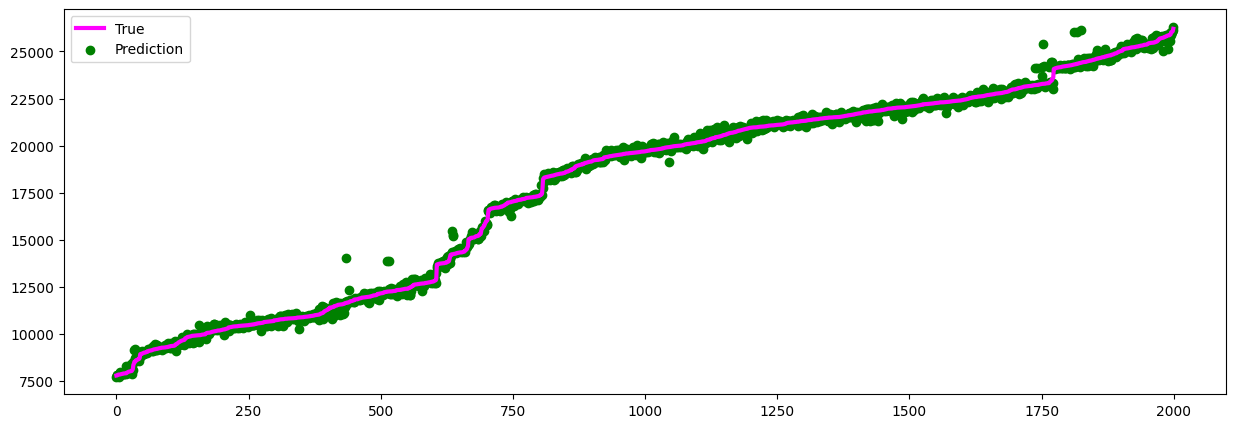

In [54]:
plotCurve(y_test, y_pred, endInd=len(y_test))

In [57]:
plot_histo(y_test.to_numpy(), y_pred, nbars=20, width = 0.08)

IndexError: list index out of range

### Cross validation

In [ ]:
maxepochs = 70
learning_rate = 1e-3
kf = KFold(n_splits=5, shuffle=True)
results = {
    "MAE": [],
    "RMSE": [],
    "R2": []
}
n_split=0
lossProgress_train = []
lossProgress_test = []

for train_index, test_index in kf.split(x):

    print("split", n_split, "----------------------------------------------------")

    x_train, y_train = x.iloc[train_index], y.iloc[train_index]
    x_test, y_test = x.iloc[test_index], y.iloc[test_index]

    #normalizing data, only according to train data mean and variance
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # Prepare dataset
    dataset = MyDataset(x=x_train, y=y_train.to_numpy())
    dataset_test = MyDataset(x=x_test, y=y_test.to_numpy())
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

    # prepare model
    # Initialize the MLP
    mlp = MLP()

    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

    for epoch in range(maxepochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            if i % 1000 == 0: print("training on batch", i)
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = mlp(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}] loss: {running_loss / len(trainloader):.3f}')
        lossProgress_train.append(running_loss / len(trainloader))

        #getting loss for test
        running_loss_test = 0.0
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # forward + backward + optimize
            outputs = mlp(inputs)
            loss = loss_function(outputs, labels)
            running_loss_test += loss.item()
        print(f'[{epoch + 1}] test loss: {running_loss_test / len(testloader):.3f}')
        lossProgress_test.append(running_loss_test / len(testloader))
    print('Finished Training')

    #eval
    y_pred = mlp(torch.tensor(x_test, dtype=torch.float32)).squeeze(-1).detach().numpy()
    print("Rapport split", n_split)
    mae, rmse, r2 = model_rapport("MLP", y_test=y_test, y_pred=y_pred)
    results["MAE"].append(mae)
    results["RMSE"].append(rmse)
    results["R2"].append(r2)

    n_split += 1


split 0 ----------------------------------------------------
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
[1] loss: 10414347.532
[1] test loss: 86857.420
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
[2] loss: 54082.183
[2] test loss: 36449.955
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
[3] loss: 28151.608
[3] test loss: 20955.427
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on batch 5000
training on batch 6000
[4] loss: 16811.394
[4] test loss: 14587.589
training on batch 0
training on batch 1000
training on batch 2000
training on batch 3000
training on batch 4000
training on 

In [35]:
print("Final results : ")
print("MAE : ", round(np.array(results["MAE"]).mean(), 8))
print("RMSE : ", round(np.array(results["RMSE"]).mean(), 8))
print("R2 : ", round(np.array(results["R2"]).mean(), 8))
print("R2 variance: ", round(np.array(results["R2"]).var(), 8))

Final results : 
MAE :  0.01640126
RMSE :  0.02229755
R2 :  0.99949957


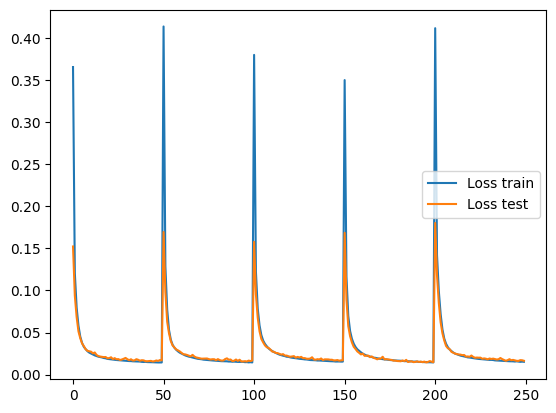

In [36]:
plt.plot([i for i in range(n_split*maxepochs)], lossProgress_train, label="Loss train")
plt.plot([i for i in range(n_split*maxepochs)], lossProgress_test, label="Loss test")
plt.legend()